#Imports and Data Set Reading

In [ ]:
import networkx as nx 
import time
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Data Sets - Colab/IR Assignments/web_graph.gpickle"
web_graph = nx.read_gpickle(path)
web_graph

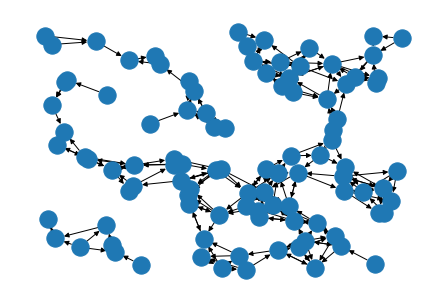

In [ ]:
#Visualization
pos = {i: web_graph.nodes[i]['pos'] for i in range(len(web_graph.nodes))}
nx.draw(web_graph, pos)

In [ ]:
#Accessing page content of any page: 
#get the 50th page content
node_index = 50
web_graph.nodes[node_index]['page_content']

'Sports: Giddy Phelps Touches Gold for First Time Michael Phelps won the gold medal in the 400 individual medley and set a world record in a time of 4 minutes 8.26 seconds.'

#Function to Create Posting List - Root Set of Pages
Given a query (say leukemia), a text index gets all pages containing leukemia. This is aka the root set of pages.

In [ ]:
#Function to remove punctuation marks
def Remove_Punctuations(data):
  punc_list = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

  for i in data:
    if i in punc_list:
        data = data.replace(i, "")

  return data  

In [ ]:
#Since we arent working with phrase queries, we dont need to store multiple occurences of the same word. 
def save_unique_words(data):
  vocab = []
  for i in data.split(): #.split() to tokenize the sentence into individual words
    if i not in vocab: #Stores unique words for that document - used to build the posting lists
      vocab.append(i)
  return vocab

In [ ]:
#Create a posting list
def create_posting_list(data_dictionary):
  #data_dictionary - Key = doc number, value = list of words in the doc
  postings = {} #Posting list is a dictionary. Key = word, value = list of doc indices. 
  for key in data_dictionary: #For each document
    doc_data = data_dictionary[key] #Temporary Variable which Stores all unique words in that document
    for word in doc_data: #For each word in the document
      if word not in postings: 
        postings[word] = []
        postings[word].append(key)
      else:
        postings[word].append(key)
    
  return postings

In [ ]:
data_dictionary = {}
for i in range(100): #We have 100 web pages in the data set.
  data = web_graph.nodes[i]['page_content'] #Stores data present in the ith web page.
  data = data.lower() #Convert everything to lowercase. 
  data = Remove_Punctuations(data)
  data = save_unique_words(data)
  data_dictionary[i] = data #Make a dictionary. Key = doc number, value = list of unique words in the doc

In [ ]:
#Call Function to create a posting list
postings = create_posting_list(data_dictionary)
postings;

In [ ]:
#Get Root Set of pages for a given example query word: 
def root_set_computation(query):
  posting_list = list(range(0, 100))
  try: 
    for i in query.split():
      l = postings[i]
      posting_list = set(l).intersection(posting_list)
    return posting_list
  except: 
    print("Some word not found in any of the web pages")

#Compute Base Set of Query Word
The base set of pages, includes the root set as well as any page that either links to a page in the root set, or is linked to by a page in the root set.

The base set is used for computing hub and authority scores because: 
1. A good authority page may not contain the query text (such as computer
hardware).
2. If the text query manages to capture a good hub page vh
in the root set, then the inclusion of all pages linked to by any page in the root set will capture all the good authorities linked to by vh in the base set.
3. Conversely, if the text query manages to capture a good authority page
va in the root set, then the inclusion of pages which point to va will bring other good hubs into the base set. In other words, the “expansion” of
the root set into the base set enriches the common pool of good hubs and
authorities.

In [ ]:
def compute_base_set(query):
  #First fetch the root set using the posting list. 
  root_set = root_set_computation(query)
  #For each node in the root set, find all nodes that are linked to/linked by that node. 
  #root_set is a set. Convert it to list. 
  root_set = list(root_set)
  base_set = root_set[:] 
  for i in root_set: 
    for j in nx.all_neighbors(web_graph, i): #all_neighbors - in build networkX function. Returns pointer to all neighbors in a connected graph. 
      if j not in base_set:
        base_set.append(j)

  return root_set, base_set

#Compute Hub, Authoritative Scores

In [ ]:
#Print Base Set of pages for a given example query word: 
query = "fossil"
try: 
  root_set, base_set = compute_base_set(query)
  print("Root set of the query is: ", root_set)
  print("Base set of the query is: ", base_set)
except: 
  print("Some Word not found in any of the web pages") #Error Handling

Root set of the query is:  [42]
Base set of the query is:  [42, 35, 44, 82]


In [ ]:
#Compute adjacency matrix of the web graph 
adj = nx.adjacency_matrix(web_graph)
#We have 256 edges in the dataset. 
#So, adj is a sparse matrix of type '<class 'numpy.longlong'>' with 256 stored elements in Compressed Sparse Row format



"""
We compute the adjacency matrix of the sub graph
Its dimensions will be len(base_set)*len(base_set)
Using each node in the base set, we compute the new adjacency matrix.
This is done by checking if each pair of nodes in the base_set has an edge in the adjacency matrix adj.   
"""
n = len(base_set)
A = np.zeros((n,n), dtype=float)
for i in base_set: 
  for j in base_set: 
    if adj[i, j]==1: 
      A[base_set.index(i), base_set.index(j)] = 1 #We comput the index of the element in base_set and place 1 in that position because it is a reduced matrix. 
print("Adjacency matrix of the subgraph is: ")
print(A)

#Compute the matrix multiplications 
AAT = np.dot(A, A.T)
ATA = np.dot(A.T, A)

#Compute principle left eigen values to get the hub, authoritative scores. 
def package_computation(matrix):
    #matrix = np.array(matrix) #Convert list to np.array form
    v, V = np.linalg.eig(matrix.T) #Left eigen value computation function
    left_vec = V[:, 0].T
    left_vec = left_vec / sum(left_vec)#Normalise the values to get prob values. Otherwise, negative values/values adding to >1 are possible. 
    return left_vec

hub = package_computation(AAT)
auth = package_computation(ATA)

print("Hub scores are: ") 
print(hub)
temp = -1*hub #For descending order (argmax uses A.O)
page_ranks = (temp).argsort()[:n]
print("The page ranks (wrt hub score) are: ")
for i in page_ranks:  
  print(base_set[i])


print("Authoritative scores are: ")
print(auth)
temp = -1*auth #For descending order (argmax uses A.O)
page_ranks = (temp).argsort()[:n]
print("The page ranks (wrt authoritative score) are: ")
for i in page_ranks:  
  print(base_set[i])


Adjacency matrix of the subgraph is: 
[[0. 0. 0. 1.]
 [1. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
Hub scores are: 
[-0.          0.41421356  0.29289322  0.29289322]
The page ranks (wrt hub score) are: 
35
82
44
42
Authoritative scores are: 
[0.70710678 0.         0.29289322 0.        ]
The page ranks (wrt authoritative score) are: 
42
44
35
82


#Verification Using HITS Inbuilt Function

In [ ]:
sg = web_graph.subgraph(base_set) #Build subgraph using the base set. 
#Compute the hub, authoritative scores. 
nx.hits(sg, max_iter=100, tol=1e-08, nstart=None, normalized=True)

({35: 0.414213562373095,
  42: -1.428631173809396e-17,
  44: 0.2928932188134525,
  82: 0.2928932188134525},
 {35: -0.0,
  42: 0.7071067811865476,
  44: 0.29289321881345254,
  82: -3.4490207554396385e-17})

#Run Time Graphs

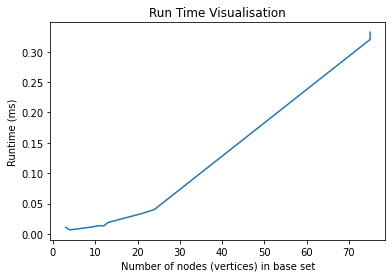

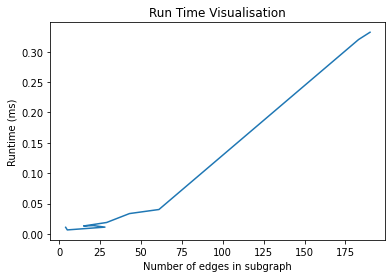

In [ ]:
#Test cases attempted: mobile, fossil, killing, sports gold win, china, launches, won, more, business, sports
runtimes = [0.0109, 0.0066, 0.0112, 0.0137, 0.01309, 0.01881, 0.033515, 0.0402, 0.32, 0.332]
nodes = [3, 4, 9, 11, 12, 13, 21, 24, 75, 75] 
edges = [4, 5, 28, 21, 15, 29, 43, 61, 183, 190]

plt.plot(nodes, runtimes)  # Plot the chart
plt.xlabel("Number of nodes (vertices) in base set")  # add X-axis label
plt.ylabel("Runtime (ms)")  # add Y-axis label
plt.title("Run Time Visualisation")  # add title
plt.show()

plt.plot(edges, runtimes)  # Plot the chart
plt.xlabel("Number of edges in subgraph")  # add X-axis label
plt.ylabel("Runtime (ms)")  # add Y-axis label
plt.title("Run Time Visualisation")  # add title
plt.show()